In [39]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset


In [40]:
import pandas as pd
df = pd.read_csv('/content/Dry_Bean_Dataset - Dry_Beans_Dataset.csv')
print("Dataset Information:")
print(df.info())
print("\nFirst Few Rows of the Dataset:")
print(df.head())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRation     13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  int64  
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  Class            13611 non-null  obje

In [41]:
#The size of classes
classes = df['Class'].unique()
num_classes = len(classes)
print("\nClasses:", classes)
print("Number of Classes:", num_classes)

#The features
features = df.columns[:-1]
num_features = len(features)
print("\nFeatures:", features)
print("Number of Features:", num_features)



Classes: ['SEKER' 'BARBUNYA' 'BOMBAY' 'CALI' 'HOROZ' 'SIRA' 'DERMASON']
Number of Classes: 7

Features: Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4'],
      dtype='object')
Number of Features: 16


In [42]:
import torch
import torch.nn as nn
import torch.optim as optim

# Defined the neural network model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

#  Number of Classes and Features
input_size = num_features
hidden_size = 128
output_size = num_classes

# Created the model
model = MLP(input_size, hidden_size, output_size)


In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
from sklearn.model_selection import train_test_split

# Split
X_train, X_temp, y_train, y_temp = train_test_split(df[features], df['Class'], test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [38]:

num_epochs = 15
train_losses = []
valid_losses = []
train_accuracies = []  # to store training accuracy

scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0

    for inputs, labels in zip(X_train.values, y_train):
        optimizer.zero_grad()
        inputs = torch.tensor(inputs, dtype=torch.float32)
        label = torch.tensor(classes.tolist().index(labels), dtype=torch.long)
        outputs = model(inputs)
        loss = criterion(outputs.unsqueeze(0), label.unsqueeze(0))
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 0)
        total += 1
        correct += (predicted == label).item()

    # Calculate training accuracy
    train_accuracy = correct / total
    train_accuracies.append(train_accuracy)

    # Save(training loss)
    train_losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        valid_loss = 0
        for inputs, labels in zip(X_valid.values, y_valid):
            inputs = torch.tensor(inputs, dtype=torch.float32)
            label = torch.tensor(classes.tolist().index(labels), dtype=torch.long)
            outputs = model(inputs)
            valid_loss += criterion(outputs.unsqueeze(0), label.unsqueeze(0)).item()

    # Save validation loss
    valid_losses.append(valid_loss / len(y_valid))

    scheduler.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss.item()}, Training Accuracy: {train_accuracy}, Validation Loss: {valid_loss / len(y_valid)}')


Epoch 1/10, Training Loss: 1.8337082822938224, Validation Loss: 1.8354276725757834
Epoch 2/10, Training Loss: 1.8337683063170536, Validation Loss: 1.8354322122196494
Epoch 3/10, Training Loss: 1.8337699663380054, Validation Loss: 1.8354322431019774
Epoch 4/10, Training Loss: 1.8337700391248677, Validation Loss: 1.8354322349289605
Epoch 5/10, Training Loss: 1.8337700462071032, Validation Loss: 1.8354322191667136
Epoch 6/10, Training Loss: 1.833496960935956, Validation Loss: 1.8352147347196193
Epoch 7/10, Training Loss: 1.833347369456599, Validation Loss: 1.8351152677610736
Epoch 8/10, Training Loss: 1.8332741061950688, Validation Loss: 1.8350703651477729
Epoch 9/10, Training Loss: 1.8332366697107794, Validation Loss: 1.8350510801554427
Epoch 10/10, Training Loss: 1.83321666815129, Validation Loss: 1.835043783577836


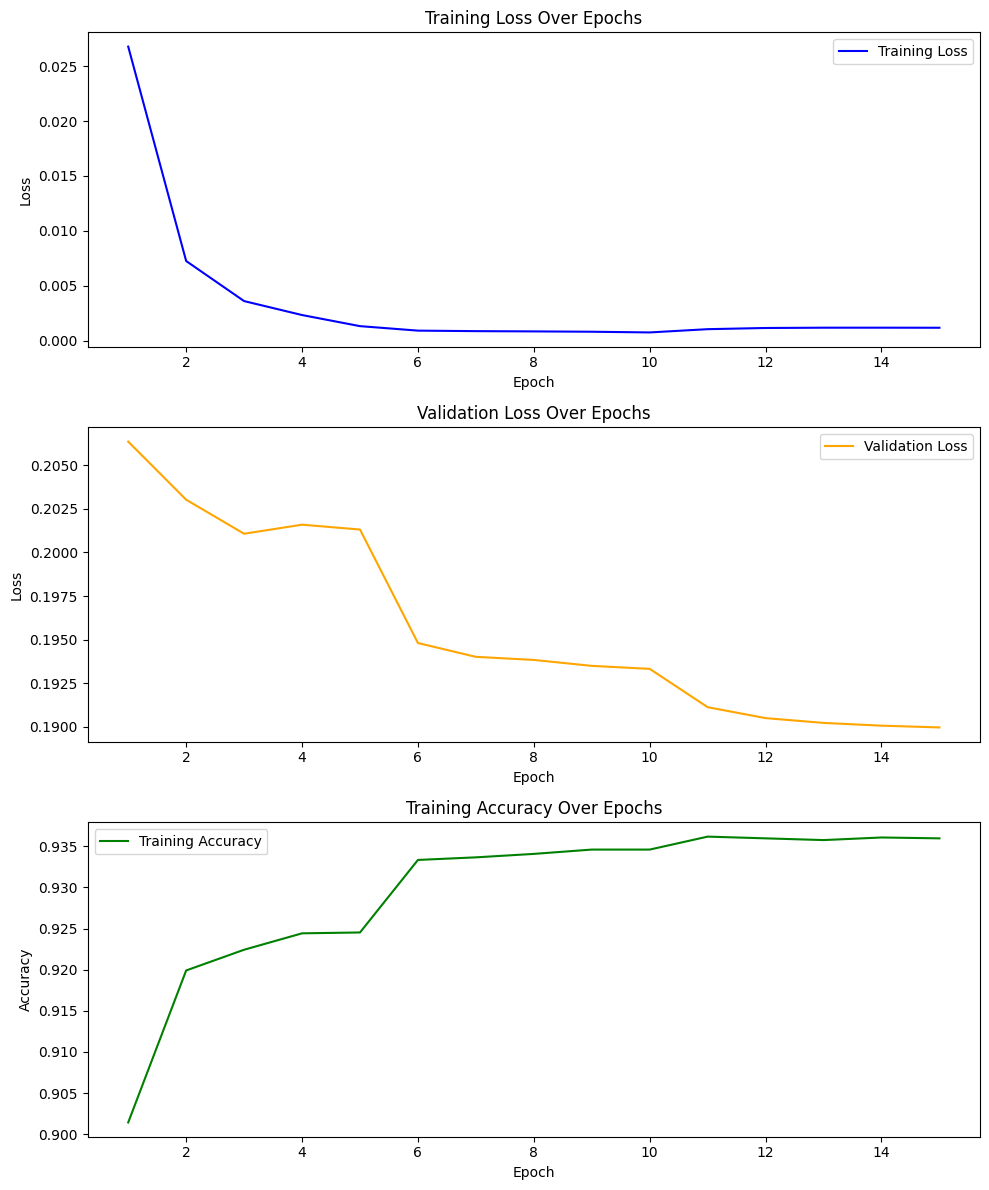

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Printing test accuracy in %

In [ ]:
#Seting the model to evaluation mode
model.eval()
with torch.no_grad():
    correct_test = 0
    total_test = 0

    for inputs, labels in zip(X_test.values, y_test):
        inputs = torch.tensor(inputs, dtype=torch.float32)
        label = torch.tensor(classes.tolist().index(labels), dtype=torch.long)
        outputs = model(inputs)
        _, predicted_test = torch.max(outputs, 0)
        total_test += 1
        correct_test += (predicted_test == label).item()

    test_accuracy = correct_test / total_test
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 93.54%
